# Задача 5. Экспериментальное исследование алгоритмов для регулярных запросов
# Автор: [bozhnyukAlex](https://github.com/bozhnyukAlex)
## Введение

Дано: граф $G$, конечный автомат которого допускает регулярный язык $L_G$

Регулярное выражение $R$, которое задает регулярный язык ограничений $L_R$

Рассмотрим задачу $RPQ = \{(v_i, v_j)|\exists\pi:w(v_i\pi v_j)\in L, v_i\in V_S, v_j\in V_F\}$, где $L = L_G\cap L_R$

Построение языка пересечения задается через пересечение конечных автоматов $КА_{G}$ и $КА_{R}$.

По определению $КА_3 = КА_1\cap КА_2 = (S^{1}\times S^{2}, \Delta^{3}, S^{1}_S\times S^{2}_S, S^{1}_F\times S^{2}_F)$, где функция переходов задаётся как
$\Delta^{3}: (v_i, v_j)\times l\rightarrow (u_i, u_j)$

$
\begin{cases}
v_i\in S^{1}\times l\rightarrow u_i\in S^{1}\quad\in\Delta^{1} \\
v_j\in S^{2}\times l\rightarrow u_j\in S^{2}\quad\in\Delta^{2}
\end{cases}$

Построение функции переходов основывается на тензорном произведении матриц смежностей конечных автоматов. В работе исследуются разные реализации алогоритма пересечения конечных автоматов.

## Постановка задачи
Задача посвящена анализу производительности различных реализаций алгоритма решения задачи достижимости между всеми парами вершин с регулярными ограничениями через тензорное произведение.
Для экспериментального исследования алгоритмов для регулярных запросов необходимо:
- Используя pyCuBool реализовать алгоритм пересечения двух конечных автоматов через тензорное произведение;
- Подключить написанный алгоритм из Задания 4;
- Сформировать набор данных для экспериментов;
- Произвести сравнительный анализ производительности реализаций алгоритмов.

## Дополнительные библиотеки
Для проведения экспериментов и других вспомогательных действий потребуется библиотека для работы с таблицами [pandas](https://pandas.pydata.org/) и библиотека для работы с графиками (...). В ячейке ниже проводится их установка.

In [ ]:
!pip install pandas
!pip install seaborn

# Исследуемые решения

Матрицы смежности конечных автоматов приводятся к виду булевых матриц для избежания необходимости вводить операцию пересечения множеств в тензорном произведении (элементы матрицы смежности - подмножества меток). Булевы матрицы на практике являются сильно разреженными, для работы с ними используются следующие библиотеки:

- [pyCuBool](https://pypi.org/project/pycubool/)
- [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html)

В scipy.sparce используются `dok` матрицы, в pyCuBool – матрицы, позволяющие производить вычисления на GPU.


## Решение с библиотекой scipy.sparce

Для доступа к решению к данному типу решения требуется подключить [следующий репозиторий](https://github.com/bozhnyukAlex/formal-lang-course).

Ниже осуществляется это подключение.


In [ ]:
import sys

# Установка проекта https://github.com/bozhyukAlex/formal-lang-course
!git clone https://github.com/bozhnyukAlex/formal-lang-course

# Установка зависимостей проекта
!pip install --upgrade pip
!pip install -r formal-lang-course/requirements.txt

# Подключение директории проекта
sys.path.insert(1, 'formal-lang-course')

## Решение с библиотекой pyCuBool

Ниже приведены реализация класса для пересечения булевых матриц, а также реализация задачи $RPQ$ с помощью библиотеки pyCuBool.



### Установка библиотеки pyCuBool

In [ ]:
!pip install pycubool

### Реализация класса для работы с булевыми матрицами

In [ ]:
import pycubool as cb

from pyformlang.finite_automaton import NondeterministicFiniteAutomaton, State


class BooleanMatricesCB:
    """
    Class representing boolean adjacency matrices
    for each label of finite automaton

    Attributes
    ----------
    indexed_states: dict
        Renumbered (from 0) states of NFA
    start_states: set
        Start states of NFA
    final_states: set
        Final states of NFA
    bool_matrix: dict
        Dictionary of boolean matrices.
        Keys are NFA labels
    block_size: int
        Size of a block in boolean matrix
    """

    def __init__(self):
        self.indexed_states = {}
        self.start_states = set()
        self.final_states = set()
        self.bool_matrix = dict()
        self.block_size = 1

    @classmethod
    def from_nfa(cls, nfa: NondeterministicFiniteAutomaton):
        """
        Transforms NFA into BooleanMatricesCB

        Parameters
        ----------
        nfa: NondeterministicFiniteAutomaton
            NFA to transform
        Returns
        -------
        obj: BooleanMatricesCB
            BooleanMatricesCB object from NFA
        """
        obj = cls()
        obj.indexed_states = {state: idx for idx, state in enumerate(nfa.states)}
        obj.start_states, obj.final_states = nfa.start_states, nfa.final_states
        obj.bool_matrix = obj._nfa_to_bool_matrix(nfa)
        return obj

    def to_nfa(self):
        """
        Transforms BooleanMatricesCB into NFA

        Returns
        -------
        nfa: NondeterministicFiniteAutomaton
            Representation of BooleanMatricesCB as NFA
        """
        nfa = NondeterministicFiniteAutomaton()
        for label in self.bool_matrix.keys():
            length = self.bool_matrix[label].shape[0]
            arr = self.bool_matrix[label].to_list()
            for i in range(length):
                for j in range(length):
                    if (i, j) in arr:
                        from_state = (
                            State((i // self.block_size, i % self.block_size))
                            if self.block_size > 1
                            else State(i)
                        )
                        to_state = (
                            State((j // self.block_size, j % self.block_size))
                            if self.block_size > 1
                            else State(j)
                        )
                        nfa.add_transition(
                            self.indexed_states[from_state],
                            label,
                            self.indexed_states[to_state],
                        )

        for start_state in self.start_states:
            nfa.add_start_state(self.indexed_states[State(start_state)])
        for final_state in self.final_states:
            nfa.add_final_state(self.indexed_states[State(final_state)])

        return nfa

    def transitive_closure(self):
        """
        Computes transitive closure of boolean matrices

        Returns
        -------
        tc: dok_matrix
            Transitive closure of boolean matrices
        """
        if not self.bool_matrix.values():
            return cb.Matrix.empty(shape=(2, 2))

        shape = list(self.bool_matrix.values())[0].shape
        tc = cb.Matrix.empty(shape=shape)

        for elem in self.bool_matrix.values():
            tc = tc.ewiseadd(elem)

        prev_nnz = tc.nvals
        curr_nnz = 0

        while prev_nnz != curr_nnz:
            tc = tc.ewiseadd(tc.mxm(tc))
            prev_nnz, curr_nnz = curr_nnz, tc.nvals

        return tc

    def _nfa_to_bool_matrix(self, nfa: NondeterministicFiniteAutomaton):
        """
        Parameters
        ----------
        nfa: NondeterministicFiniteAutomaton
            NFA to transform to matrix

        Returns
        -------
        bool_matrix: dict
            Dict of boolean matrix for every automata label-key
        """
        bool_matrix = dict()
        nfa_dict = nfa.to_dict()
        for label in nfa.symbols:
            tmp_matrix = cb.Matrix.empty(shape=(len(nfa.states), len(nfa.states)))
            for state_from, transitions in nfa_dict.items():
                if label in transitions:
                    states_to = (
                        transitions[label]
                        if isinstance(transitions[label], set)
                        else {transitions[label]}
                    )
                    for state_to in states_to:
                        tmp_matrix[
                            self.indexed_states[state_from],
                            self.indexed_states[state_to],
                        ] = True
            bool_matrix[label] = tmp_matrix
        return bool_matrix

    def intersect(self, other):
        """
        Returns a new class object containing
        the Kronecker products for given matrices

        Parameters
        ----------
        other: BooleanMatricesCB
            Right-hand side boolean matrix
        Returns
        -------
        intersection: BooleanMatricesCB
            Intersection of two boolean matrices
        """
        intersection = BooleanMatricesCB()
        common_labels = self.bool_matrix.keys() & other.bool_matrix.keys()

        for label in common_labels:
            intersection.bool_matrix[label] = self.bool_matrix[label].kronecker(other.bool_matrix[label])

        for state_lhs, s_lhs_index in self.indexed_states.items():
            for state_rhs, s_rhs_index in other.indexed_states.items():
                new_state = new_state_idx = (
                    s_lhs_index * len(other.indexed_states) + s_rhs_index
                )
                intersection.indexed_states[new_state] = new_state_idx

                if state_lhs in self.start_states and state_rhs in other.start_states:
                    intersection.start_states.add(new_state)

                if state_lhs in self.final_states and state_rhs in other.final_states:
                    intersection.final_states.add(new_state)

        return intersection

### Реализация алгоритма для решения задачи $RPQ$

In [ ]:
from networkx import MultiDiGraph
from pyformlang.regular_expression import Regex

from project import graph_to_nfa


def rpqCB(
    graph: MultiDiGraph, query: Regex, start_nodes: set = None, final_nodes: set = None
):
    """
    This function solves Regular Path Querying problem for
    giving graph, regex query with possibility of input start and final nodes

    Parameters
    ----------
    graph: nx.MultiDiGraph
        Graph for working with queries
    query: Regex
        Query represented by regex
    start_nodes:
        Set of start nodes in graph
    final_nodes:
        Set of final nodes in graph

    Returns
    -------
    set:
        Set of pairs with answer to RPG problem

    """

    graph_bm = BooleanMatricesCB.from_nfa(
        graph_to_nfa(graph, start_nodes, final_nodes)
    )
    query_bm = BooleanMatricesCB.from_nfa(query.to_epsilon_nfa().minimize())

    intersection = graph_bm.intersect(query_bm)
    tc = intersection.transitive_closure()

    result = set()
    for state_from, state_to in tc.to_list():
        if (
            state_from in intersection.start_states
            and state_to in intersection.final_states
        ):
            result.add(
                (
                    state_from // len(query_bm.indexed_states),
                    state_to // len(query_bm.indexed_states),
                )
            )

    return result

# Описание данных для экспериментов




## Графы

В качестве графов $G$ будем использовать графы из [RDF](https://jetbrains-research.github.io/CFPQ_Data/dataset/RDF.html) датасета.

### Имена графов

In [ ]:
GRAPH_NAMES = (
     "skos",
     "generations",
     "travel",
     "univ_bench",
     "atom_primitive",
     "biomedical_mesure_primitive",
     "foaf",
     "people_pets",
     "funding",
     "wine",
     "pizza",
     "core",
     "pathways",
     "enzyme",
     "eclass_514en",
     "go_hierarchy",
     "go",
     "geospecies",
)

### Информация о графах

В таблице ниже приведена информация о количестве вершин и ребер для каждого используемого графа.

In [ ]:
from project import get_graph_info
import pandas as pd



e_counts = []
n_counts = []
l_counts = []

for graph_name in GRAPH_NAMES:
  graph_info = get_graph_info(graph_name)
  edges_count, nodes_count = graph_info.nodes_count, graph_info.edges_count
  l_count = len(graph_info.labels)
  e_counts.append(edges_count)
  n_counts.append(nodes_count)
  l_counts.append(l_count)
  
df = pd.DataFrame(
    {
      "Edges count": e_counts,
      "Nodes count": n_counts,
      "Labels count": l_counts
    },
    index=GRAPH_NAMES
)
df
  

file:///usr/local/lib/python3.7/dist-packages/cfpq_data/data/RDF/Graphs/<http:/sw.opencyc.org/concept/Mx4rvVi495wpEbGdrcN5Y29ycA> does not look like a valid URI, trying to serialize this will break.
file:///usr/local/lib/python3.7/dist-packages/cfpq_data/data/RDF/Graphs/<http:/sw.opencyc.org/concept/Mx4rvVi495wpEbGdrcN5Y29ycA> does not look like a valid URI, trying to serialize this will break.


,Edges count,Nodes count,Labels count
skos,144,252,21
generations,129,273,17
travel,131,277,22
univ_bench,179,293,14
atom_primitive,291,425,17
biomedical_mesure_primitive,341,459,10
foaf,256,631,15
people_pets,337,640,25
funding,778,1086,20
wine,733,1839,35


## Запросы

Запросы представляют из себя регулярные выражения.
В рамках подготовки к эксперименту они подбираются так, чтобы в них использовались все общепринятые конструкции регулярных выражений (замыкание, конкатенация, альтернатива).

В итоге, имеется следующий набор из четырех запросов:
- $L_1\ (L_2\  |\  L_3)^*$
- $L_1^*\  (L_2\  |\  L_3)^*$
- $(L_4\  |\  L_2)^*\  L_1\  L_2\  l_3$
- $(L_1\  |\  L_4)^*\  |\ (L_2\  |\  L_3)^*$

### Генерация запросов

Функции ниже отвечают за генерацию запросов как регулярных выражений.

In [ ]:
from pyformlang.regular_expression.regex_objects import Symbol

def regex_from_label(label):
  regex = Regex("")
  regex.head = Symbol(str(label))
  return regex

def regex_first(labels):
  """
  L1 (L2 | L3)*
  """
  len_labels = len(labels)
  if len_labels >= 3:
    regex_1 = regex_from_label(labels[0])
    regex_2 = regex_from_label(labels[1])
    regex_3 = regex_from_label(labels[2])
  elif len_labels == 2:
    regex_1 = regex_from_label(labels[0])
    regex_2 = regex_from_label(labels[1])
    regex_3 = regex_2
  elif len_labels == 1:
    regex_1 = regex_from_label(labels[0])
    regex_2 = regex_1
    regex_3 = regex_2

  return regex_1.concatenate((regex_2.union(regex_3)).kleene_star())

def regex_second(labels):
  """
   L1* (L2 | L3)*
  """
  len_labels = len(labels)
  if len_labels >= 3:
    regex_1 = regex_from_label(labels[0])
    regex_2 = regex_from_label(labels[1])
    regex_3 = regex_from_label(labels[2])
  elif len_labels == 2:
    regex_1 = regex_from_label(labels[0])
    regex_2 = regex_from_label(labels[1])
    regex_3 = regex_2
  elif len_labels == 1:
    regex_1 = regex_from_label(labels[0])
    regex_2 = regex_1
    regex_3 = regex_2

  return regex_1.kleene_star().concatenate((regex_2.union(regex_3).kleene_star()))

def regex_third(labels):
  """
  (L4 | L2)* L1 L2 L3
  """ 
  len_labels = len(labels)
  if len_labels >= 4:
    regex_1 = regex_from_label(labels[0])
    regex_2 = regex_from_label(labels[1])
    regex_3 = regex_from_label(labels[2])
    regex_4 = regex_from_label(labels[3])
  elif len_labels == 3:
    regex_1 = regex_from_label(labels[0])
    regex_2 = regex_from_label(labels[1])
    regex_3 = regex_from_label(labels[2])
    regex_4 = regex_3
  elif len_labels == 2:
    regex_1 = regex_from_label(labels[0])
    regex_2 = regex_from_label(labels[1])
    regex_3 = regex_2
    regex_4 = regex_3
  elif len_labels == 1:
    regex_1 = regex_from_label(labels[0])
    regex_2 = regex_1
    regex_3 = regex_2
    regex_4 = regex_3

  left_regex = regex_4.union(regex_2).kleene_star()
  return left_regex.concatenate(regex_1).concatenate(regex_2).concatenate(regex_3)

def regex_fourth(labels):
  """
  (L1 | L4)* | (L2 | L3)*
  """
  len_labels = len(labels)
  if len_labels >= 4:
    regex_1 = regex_from_label(labels[0])
    regex_2 = regex_from_label(labels[1])
    regex_3 = regex_from_label(labels[2])
    regex_4 = regex_from_label(labels[3])
  elif len_labels == 3:
    regex_1 = regex_from_label(labels[0])
    regex_2 = regex_from_label(labels[1])
    regex_3 = regex_from_label(labels[2])
    regex_4 = regex_3
  elif len_labels == 2:
    regex_1 = regex_from_label(labels[0])
    regex_2 = regex_from_label(labels[1])
    regex_3 = regex_2
    regex_4 = regex_3
  elif len_labels == 1:
    regex_1 = regex_from_label(labels[0])
    regex_2 = regex_1
    regex_3 = regex_2
    regex_4 = regex_3
  left_regex = (regex_1.union(regex_4)).kleene_star()
  right_regex = (regex_2.union(regex_3)).kleene_star()
  return left_regex.union(right_regex)

REGEX_GENERATORS = (regex_first, regex_second, regex_third, regex_fourth)

# Описание экспериментов


### Методология проведения измерений

Для графов, количество рёбер и вершин которого не превышает 50.000, время выполнения функции построения $RPQ$ для каждого запроса замеряется 3 раза *(Best of 3)*. Для остальных графов (начиная с `enzyme`) время выполнение функции замеряется единожды для каждого запроса.

Данное решение обосновано незначительностью погрешности времени выполнения для "тяжелых" графов. Более того, вычислительная сложность задачи построения RPQ на подобных графах превышает вычислительные возможности бесплатного тарифа Google Colab, на котором изначально проводились данные эксперименты. 

### Среда выполнения



Операционная система:

In [ ]:
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.5 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.5 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


CPU:

In [ ]:
!lscpu | grep 'Model name'
!lscpu | grep 'Socket(s)'
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Thread(s) per core'
!lscpu | grep "MHz"

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Socket(s):           1
Core(s) per socket:  1
Thread(s) per core:  2
CPU MHz:             2299.998


GPU:

In [ ]:
!nvidia-smi

Tue Oct 12 19:16:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    31W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

RAM:

In [ ]:
!echo 'Total RAM (GB)'
!awk '( $1 == "MemTotal:" ) { print $2/1048576 }' /proc/meminfo

Total RAM (GB)
12.6867


# Эксперимент

In [ ]:
import pandas as pd

regex_str_list = ["L1 (L2 | L3)*", "L1* (L2 | L3)*", 
                  "(L4 | L2)* L1 L2 L3", "(L1 | L4)* | (L2 | L3)*"]

df_sparse_res = pd.DataFrame(index=regex_str_list, columns=GRAPH_NAMES)
df_pycubool_res = pd.DataFrame(index=regex_str_list, columns=GRAPH_NAMES)

### Формирование результатов измерений для scipy.sparse

In [ ]:
from project import get_graph_info, rpq
from cfpq_data import graph_from_dataset

for graph_name in GRAPH_NAMES:
  labels = list(get_graph_info(graph_name).labels)
  graph = graph_from_dataset(graph_name, verbose=False)
  for index, regex in enumerate(REGEX_GENERATORS):
    regular_expression = regex(labels)
    print(f"Graph: {graph_name}; Regex: {regex.__doc__} Result: ", end='')
    if index > GRAPH_NAMES.index("enzyme"):
        curr_time = %timeit -n 1 -r 1 -o result = rpq(graph, regular_expression)
    else:
        curr_time = %timeit -n 1 -r 3 -o result = rpq(graph, regular_expression)
    df_sparse_res.loc[regex_str_list[index], graph_name] = curr_time.best * 1000


### Формирование результатов измерений для pyCuBool

In [ ]:
from cfpq_data import graph_from_dataset


for graph_name in GRAPH_NAMES:
  labels = list(get_graph_info(graph_name).labels)
  graph = graph_from_dataset(graph_name, verbose=False)
  for index, regex in enumerate(REGEX_GENERATORS):
    regular_expression = regex(labels)
    print(f"Graph: {graph_name}; Regex: {regex.__doc__} Result: ", end='')
    if index >= GRAPH_NAMES.index("enzyme"):
        curr_time = %timeit -n 1 -r 1 -o result = rpqCB(graph, regular_expression)
    else:
        curr_time = %timeit -n 1 -r 3 -o result = rpqCB(graph, regular_expression)
    df_pycubool_res.loc[regex_str_list[index], graph_name] = curr_time.best * 1000
    

# Результаты экспериментов

### Алгоритм, основанный на scipy.sparse
#### Время работы алгоритма (в мс) в зависимости от графа и регулярного выражения:


In [ ]:
df_sparse_res

,Queries,skos,generations,travel,univ_bench,atom_primitive,biomedical_mesure_primitive,foaf,people_pets,funding,wine,pizza,core,pathways,enzyme,eclass_514en,go_hierarchy,go,geospecies
0,L1 (L2 | L3)*,27.507620,29.216950,28.726575,33.628161,47.885875,58.577086,59.690414,66.832614,114.577661,169.754683,175.572096,274.748120,1248.813167,8379.383736,44957.860305,34728.241203,174362.071117,195080.017497
1,L1* (L2 | L3)*,28.553018,30.307510,29.040275,32.708838,48.506873,55.176651,64.703553,67.320527,118.489582,173.989737,174.370239,273.645434,1248.305383,8518.943775,44253.928250,34775.323749,191683.117963,195737.497321
2,(L4 | L2)* L1 L2 L3,32.723814,32.373796,33.438435,35.911215,53.295124,62.544296,61.782723,74.330668,122.876851,190.271286,184.534778,289.794789,1306.699510,9071.258657,47375.948754,35560.015263,194269.924301,201066.120815
3,(L1 | L4)* | (L2 | L3)*,31.160785,33.650010,32.105690,35.054784,52.518852,58.151427,66.136575,69.087267,125.098088,184.066569,183.642657,291.481069,1279.326143,8737.727205,49194.442590,34835.132184,181362.573065,202584.917805


### Алгоритм, основанный на pycubool
#### Время работы алгоритма (в мс) в зависимости от графа и регулярного выражения:

In [ ]:
df_pycubool_res

,Queries,skos,generations,travel,univ_bench,atom_primitive,biomedical_mesure_primitive,foaf,people_pets,funding,wine,pizza,core,pathways,enzyme,eclass_514en,go_hierarchy,go,geospecies
0,L1 (L2 | L3)*,22.328282,23.096711,22.318093,25.644526,39.141207,41.848726,48.430614,55.826003,97.462780,159.631252,146.061300,244.937493,1059.690324,7410.373415,37168.790216,27316.093957,162915.342890,179216.788958
1,L1* (L2 | L3)*,22.637799,23.507626,22.365214,25.457005,38.957658,45.032373,49.106758,56.555636,96.185554,159.776661,146.432259,243.140946,1074.999626,7412.786602,37669.018073,26703.247384,163358.811113,180317.092748
2,(L4 | L2)* L1 L2 L3,22.532535,24.286403,24.392444,26.566552,41.483552,47.192517,50.901283,56.147996,104.088027,164.010024,152.106038,257.211026,1095.367551,7732.830444,39132.222589,27092.806149,163380.116678,180522.096709
3,(L1 | L4)* | (L2 | L3)*,22.901825,25.738004,24.553496,28.115576,40.657536,43.444660,49.357560,57.803577,103.491368,161.850983,148.824248,250.464707,1095.529918,7643.017224,38793.831876,26087.297380,159711.500791,174877.262997


## Количество времени на каждый запрос для каждого графа для sparse

Построим диаграммы, иллюстрирующие количество времени (в мс) на каждый запрос для каждого графа. Рассматривается решение при помощи библиотеки sparse. На оси x - номера запросов в порядке, как указано в описании запросов. По оси y - время в мс.

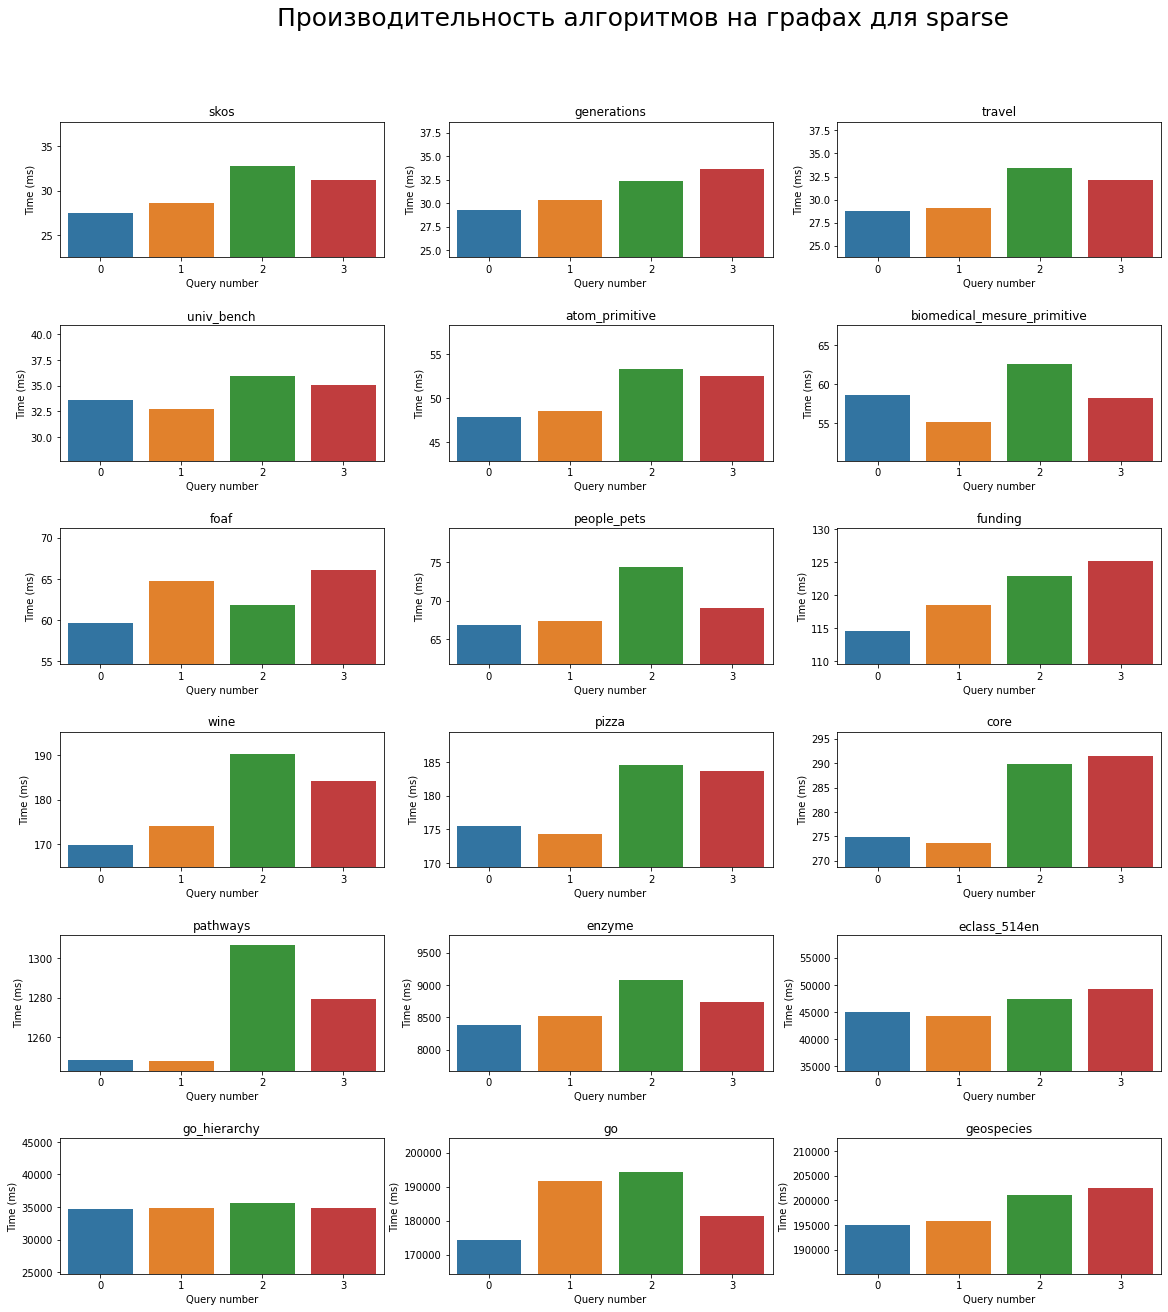

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(6, 3, figsize=(18, 20))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('Производительность алгоритмов на графах для sparse', fontsize=25)



for i, name in enumerate(GRAPH_NAMES):
    ax = sns.barplot(ax=axes[i // 3, i % 3], data=df_sparse_res, x=df_sparse_res.index, y=name)
    ax.set_title(name)

    delta = 5
    if name == "enzyme":
        delta = 700
    elif name in {"eclass_514en", "go_hierarchy", "go", "geospecies"}:
        delta = 10000

    curr_min = df_sparse_res[name].min() - delta
    curr_max = df_sparse_res[name].max() + delta

    ax.set(title=name, ylabel="Time (ms)", xlabel="Query number", ylim=(curr_min, curr_max))

plt.show()

## Количество времени на каждый запрос для каждого графа для pyCuBool

Построим диаграммы, иллюстрирующие количество времени (в мс) на каждый запрос для каждого графа. Рассматривается решение при помощи библиотеки pyCuBool. На оси x - номера запросов в порядке, как указано в описании запросов. По оси y - время в мс.

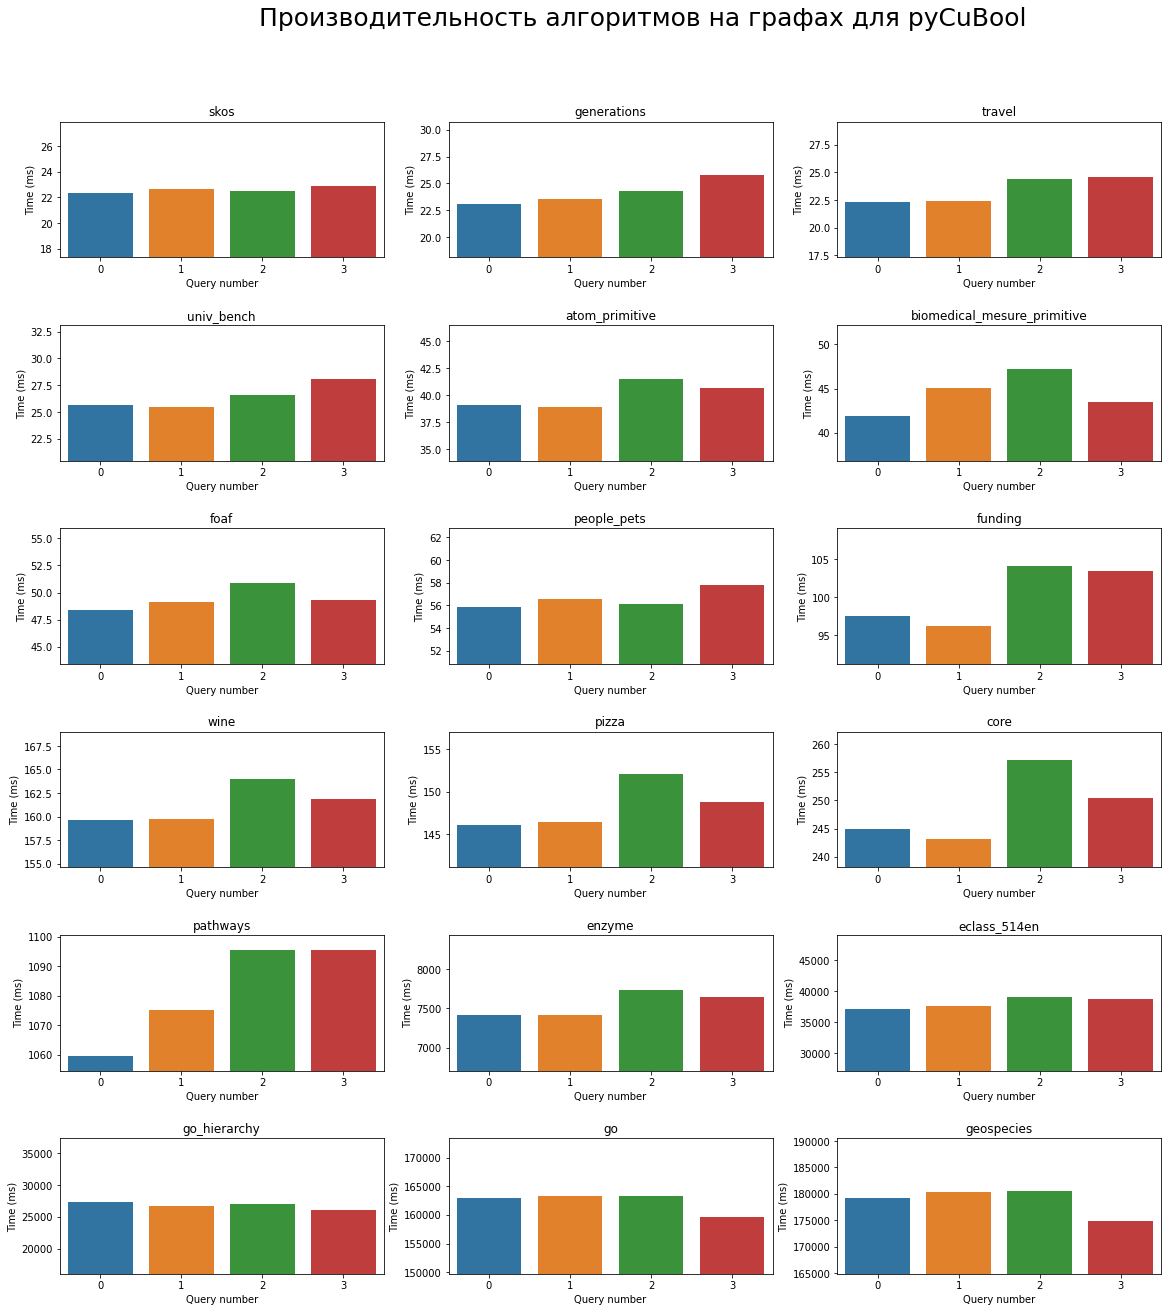

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(6, 3, figsize=(18, 20))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('Производительность алгоритмов на графах для pyCuBool', fontsize=25)


for i, name in enumerate(GRAPH_NAMES):
    ax = sns.barplot(ax=axes[i // 3, i % 3], data=df_pycubool_res, x=df_pycubool_res.index, y=name)
    ax.set_title(name)

    delta = 5
    if name == "enzyme":
        delta = 700
    elif name in {"eclass_514en", "go_hierarchy", "go", "geospecies"}:
        delta = 10000

    curr_min = df_pycubool_res[name].min() - delta
    curr_max = df_pycubool_res[name].max() + delta

    ax.set(title=name, ylabel="Time (ms)", xlabel="Query number",  ylim=(curr_min, curr_max))

plt.show()

## Результаты измерений для sparse и pyCuBool


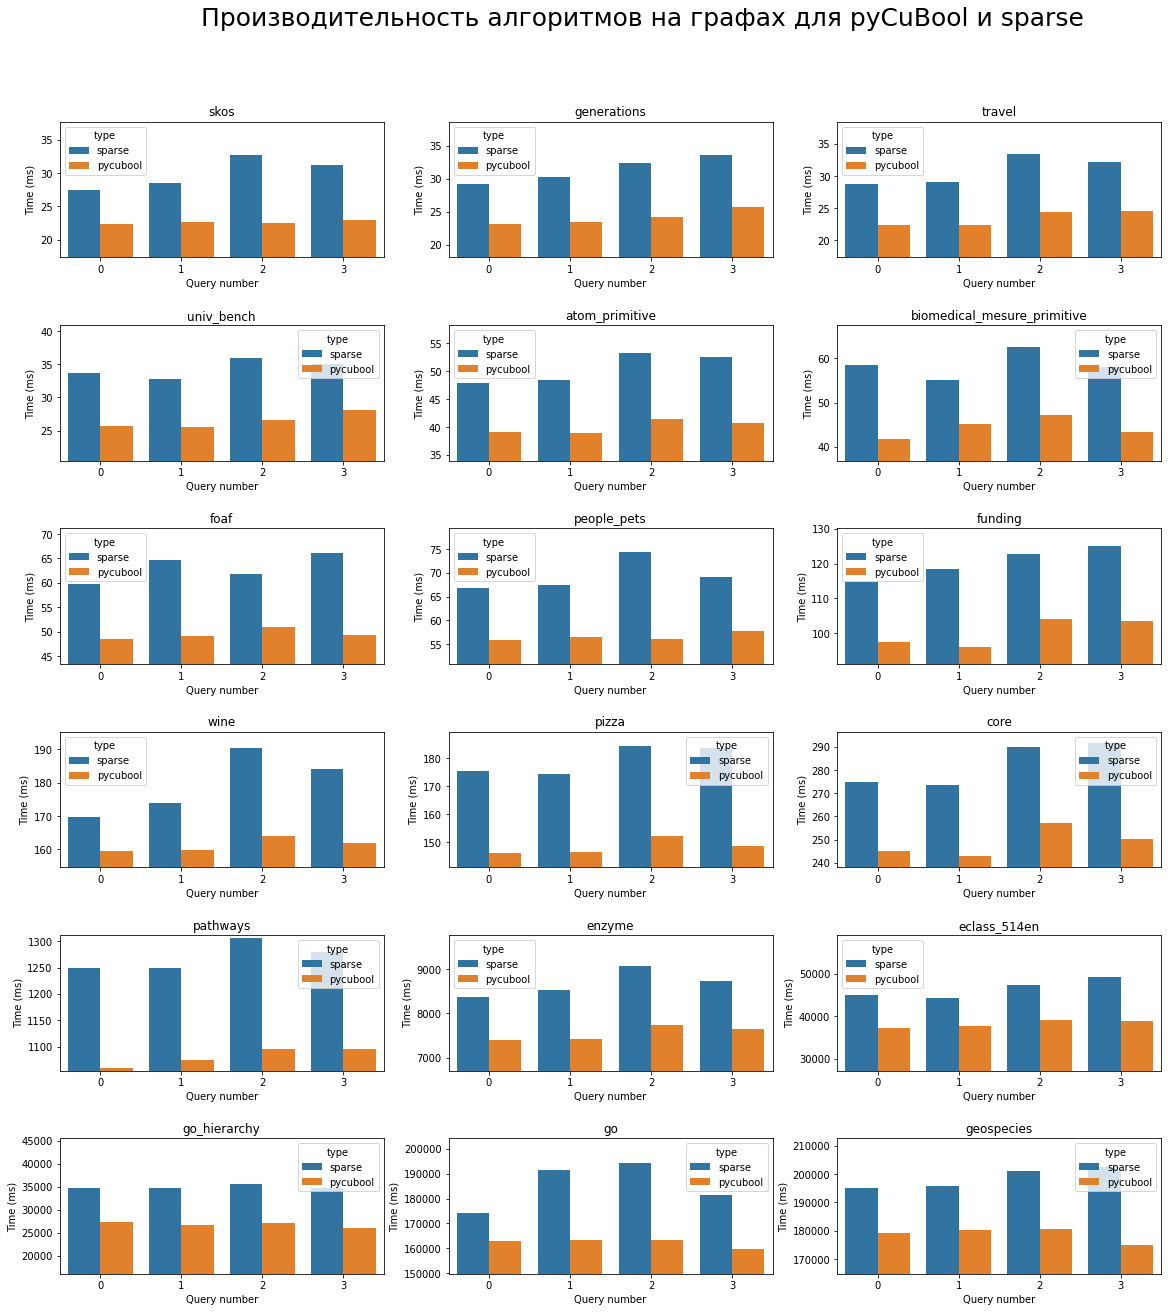

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(6, 3, figsize=(18, 20))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('Производительность алгоритмов на графах для pyCuBool и sparse', fontsize=25)

for i, graph_name in enumerate(GRAPH_NAMES):
    res_sparse = df_sparse_res[graph_name]
    res_pycubool = df_pycubool_res[graph_name]

    df_all = pd.DataFrame(pd.concat([res_sparse, res_pycubool], ignore_index=True))
    df_all['type'] = pd.Series(["sparse", "sparse", "sparse", "sparse", "pycubool", "pycubool", "pycubool", "pycubool"])

    ax = sns.barplot(ax=axes[i // 3, i % 3], data=df_all, x=df_all.index % 4, y=graph_name, hue="type")

    delta = 5
    if graph_name == "enzyme":
        delta = 700
    elif graph_name in {"eclass_514en", "go_hierarchy", "go", "geospecies"}:
        delta = 10000

    curr_min = df_all[graph_name].min() - delta
    curr_max = df_all[graph_name].max() + delta
    ax.set(title=graph_name, ylabel="Time (ms)", xlabel="Query number", ylim=(curr_min, curr_max))

plt.show()


# Вывод

По результатам диаграмм видно, что реализация алгоритма решения задачи $RPQ$ показывает лучшие результаты в случае применения библиотеки *pycubool* для реализации операций с разреженными булевыми матрицами. Это можно связать с тем фактом, что данная библиотека в своей реализации использует технологии *NVIDIA CUDA*.